In [ ]:
! git init
! git pull https://github.com/serzaraisk/noisy_labels.git

## Step 0: Imports and Global variable init

In [1]:
from torch import cuda
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
DESTINATION_FOLDER = 'models'
DATASETS_FOLDER = 'data'
TRAIN_TEST_RATIO = 0.1
TRAIN_VALID_RATIO = 0.8
FRACTION = 0.01
SAMPLE = None
PATH = '//home/images/dev/spochukaev/hse_diploma/image_classification'
BATCH_SIZE = 10
NUM_OF_WORKERS = 0

MODEL_NAME = 'tf_efficientnet_b4_ns'
efficientnet_sizes = {'tf_efficientnet_b0_ns':224,
'tf_efficientnet_b1_ns':240,
'tf_efficientnet_b2_ns':260,
'tf_efficientnet_b3_ns':300,
'tf_efficientnet_b4_ns':380,
'tf_efficientnet_b5_ns':456,
'tf_efficientnet_b6_ns':528,
'tf_efficientnet_b7_ns':600
}

IMAGE_SIZE = efficientnet_sizes[MODEL_NAME]

print(DEVICE)

cpu


## Step 1: Train_val_test_split data

In [2]:
import prepare_dataset

In [3]:
df = prepare_dataset.load_dataset(PATH)
df = prepare_dataset.sample_dataset(df, n=1000)
df = prepare_dataset.choose_toloka_answer_column(df, 'aggr_answer')
prepare_dataset.train_test_split_df(df, 'lookup_tables/', TRAIN_TEST_RATIO, TRAIN_VALID_RATIO)
df_train, df_val, df_test = prepare_dataset.get_lookup_tables('lookup_tables/')
prepare_dataset.load_pictures(df_train, df_val, df_test)

Кол-во обработанных строк [/train]: 0
http://storage.mds.yandex.net:80/get-mimcache/117819/89be5371e5083ce8359db1e01894c22f
http://storage.mds.yandex.net:80/get-mimcache/117819/89be5371e5083ce8359db1e01894c22f
Кол-во обработанных строк [/val]: 0
Кол-во обработанных строк [/test]: 0
Кол-во обработанных строк [/test]: 100
Кол-во обработанных строк [/test]: 200
Кол-во обработанных строк [/test]: 300
http://storage.mds.yandex.net:80/get-mimcache/53042/0cf672f8ab2e944daf6a3b0e59a28985
Кол-во обработанных строк [/test]: 400
Кол-во обработанных строк [/test]: 500
http://storage.mds.yandex.net:80/get-mimcache/48333/d1485a468f60b8c5f4cbc12aad3a5695
Кол-во обработанных строк [/test]: 600
http://storage.mds.yandex.net:80/get-mimcache/103011/990c356cc6f6cb3a00ed4613f3fdc619
Кол-во обработанных строк [/test]: 700
http://storage.mds.yandex.net:80/get-mimcache/53042/3feac0be8162cbc843c1a83b29fbad1d
Кол-во обработанных строк [/test]: 800


## Step 2: Load Pytorch Dataset and dataloader

In [2]:
import init_dataset_dataloader
train, valid, test = init_dataset_dataloader.create_datasets('image_dataset/', IMAGE_SIZE)
train_iter, valid_iter, test_iter = init_dataset_dataloader.create_dataloaders(train, valid, test, BATCH_SIZE, NUM_OF_WORKERS)

## Step 3: Create model

In [3]:
import model

In [4]:
pic_model_toloka = model.create_model(MODEL_NAME).to(DEVICE)
pic_model_toloka_2 = model.create_model(MODEL_NAME).to(DEVICE)
pic_model_assesor = model.create_model(MODEL_NAME).to(DEVICE)

## Step 5: Training

In [12]:
import shutil
import os
if os.path.isdir(DESTINATION_FOLDER):
    shutil.rmtree(DESTINATION_FOLDER)
os.mkdir(DESTINATION_FOLDER)

In [5]:
import train_model

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Valid_loss decreased inf --> 1.3929979801177979
save model
Epoch : 1 Train Loss : 0.579035 Train Acc : 0.809375
Epoch : 1 Valid Loss : 1.392998 Valid Acc : 0.511111


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Valid_loss decreased 1.3929979801177979 --> 0.9795626302560171
save model
Epoch : 2 Train Loss : 0.248594 Train Acc : 0.925000
Epoch : 2 Valid Loss : 0.979563 Valid Acc : 0.600000
Model saved to ==> models/first_model/first_model_metrics.pt


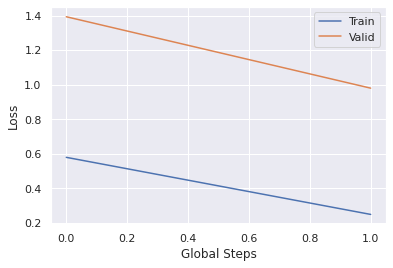

In [36]:
import torch
from torch import nn

LR = 0.001
EPOCHS = 2

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(pic_model_toloka.parameters(),lr = LR)

trainer = ImageTrainer(DEVICE, 'first_model',use_ground_for_training=False, use_ground_for_validate=False, criterion=criterion,optimizer=optimizer)
trainer.fit(pic_model_toloka,train_iter,valid_iter,EPOCHS, 'models')

In [30]:
import torch
from torch import nn

LR = 0.001
EPOCHS = 1

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(pic_model_assesor.parameters(),lr = LR)

trainer = ImageTrainer(DEVICE, 'True_model',use_ground_for_training=True, use_ground_for_validate=True, criterion=criterion,optimizer=optimizer)
trainer.fit(pic_model_assesor,train_iter,valid_iter,EPOCHS, 'models')

100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Valid_loss decreased inf --> 1.0890665849049885
save model
Epoch : 1 Train Loss : 0.485945 Train Acc : 0.871875
Epoch : 1 Valid Loss : 1.089067 Valid Acc : 0.622222
Model saved to ==> models/True_model/True_model_metrics.pt


In [31]:
import torch
from torch import nn

LR = 0.01
EPOCHS = 1

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(pic_model_toloka_2.parameters(),lr = LR)

trainer = ImageTrainer(DEVICE, 'Second_model',use_ground_for_training=True, use_ground_for_validate=True, criterion=criterion,optimizer=optimizer)
trainer.fit(pic_model_assesor,train_iter,valid_iter,EPOCHS, 'models')

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Valid_loss decreased inf --> 0.9303737680117289
save model
Epoch : 1 Train Loss : 0.406935 Train Acc : 0.803125
Epoch : 1 Valid Loss : 0.930374 Valid Acc : 0.622222
Model saved to ==> models/Second_model/Second_model_metrics.pt


## Step 6: Evaluation

In [40]:
load_checkpoint('models/first_model/first_model.pt', pic_model_toloka)
load_checkpoint('models/True_model/True_model.pt', pic_model_toloka_2)
load_checkpoint('models/Second_model/Second_model.pt', pic_model_assesor)

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]

Classification Report for model pic_model_toloka:
              precision    recall  f1-score   support

 Bad quality     0.8462    0.7586    0.8000        29
  OK quality     0.7885    0.9111    0.8454        45
Good quality     0.0000    0.0000    0.0000         4

    accuracy                         0.8077        78
   macro avg     0.5449    0.5566    0.5485        78
weighted avg     0.7695    0.8077    0.7851        78




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


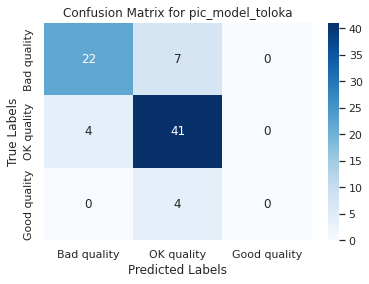

In [61]:
evaluate(pic_model_toloka, 'pic_model_toloka', train_iter, DEVICE)